# Introduction to Euclid Q1 PHZ catalog

## Learning Goals

By the end of this tutorial, you will:
- Understand the basic characteristics of Euclid Q1 photo-z catalog and how to match it with MER mosaics.
- Understand what PHZ catalogs are available and how to view the columns in those catalogs.
- How to query with ADQL in the PHZ catalog to find galaxies between a redshift of 1.4 and 1.6.
- Pull and plot a spectrum of one of the galaxies in that catalog.
- Cutout an image of the galaxy to view it close up.
- Learn how to upload images and catalogs to Firefly to inspect individual sources in greater detail.

## Introduction

Euclid is a European Space Agency (ESA) space mission with NASA participation, to study the geometry and nature of the dark Universe. The Quick Data Release 1 (Q1) are the first data release from the Euclid mission after the Early Release Observations (ERO). On March 19, 2025 the data will be available on the ESA archive (https://easidr.esac.esa.int/sas/) and on the IRSA archive (https://irsa.ipac.caltech.edu).

These notebooks focus on how to access, download, and process Euclid Q1 data from the IRSA archive. At the end of the notebook, we also include some information for how to access the Q1 data from the ESA archive. If you have any issues accessing data from the archives, please contact the helpdesk directly: IRSA (irsasupport@ipac.caltech.edu) and ESA (https://support.cosmos.esa.int/euclid).

The photometry of every source is processed through a photometric redshift fitting pipeline, producing several different catalogs. This notebook provides an introduction to photo-z catalog released as part of Euclid Q1. Other Euclid notebooks show how to use other data products released as part of Euclid Q1.

## Imports

In [1]:
# Uncomment the next line to install dependencies if needed.
# !pip install requests matplotlib pandas astropy pyvo fsspec firefly_client

In [2]:
from io import BytesIO
import os
import re

import requests
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.table import Table
from astropy import units as u
from astropy.utils.data import download_file
from astropy.visualization import ImageNormalize, PercentileInterval, AsinhStretch, LogStretch
from astropy.wcs import WCS

from firefly_client import FireflyClient
import pyvo as vo

## 1. Find the MER Tile ID that corresponds to a given RA and Dec

In this case, choose random coordinates to show a different MER mosaic image. Search a radius around these coordinates.

In [3]:
ra = 268
dec = 66
search_radius= 10 * u.arcsec

coord = SkyCoord(ra, dec, unit='deg', frame='icrs')

### Use IRSA to search for all Euclid data on this target

This searches specifically in the euclid_DpdMerBksMosaic "collection" which is the MER images and catalogs.

In [4]:
irsa_service= vo.dal.sia2.SIA2Service('https://irsa.ipac.caltech.edu/SIA')

image_table = irsa_service.search(pos=(coord, search_radius), collection='euclid_DpdMerBksMosaic').to_table()

```{note}
This table lists all MER mosaic images available in this position. These mosaics include the Euclid VIS, Y, J, H images, as well as ground-based telescopes which have been put on the same pixel scale. For more information, see the [Euclid documentation at IPAC](https://euclid.caltech.edu/page/euclid-faq-tech/).
```

In [5]:
# Convert the table to pandas dataframe
df_im_irsa=image_table.to_pandas()

In [6]:
df_im_euclid=df_im_irsa[ (df_im_irsa['dataproduct_subtype']=='science') &  (df_im_irsa['facility_name']=='Euclid')]

df_im_euclid.head()

,s_ra,s_dec,facility_name,instrument_name,dataproduct_subtype,calib_level,dataproduct_type,energy_bandpassname,energy_emband,obs_id,...,t_resolution,t_xel,obs_publisher_did,s_fov,em_xel,pol_states,pol_xel,cloud_access,o_ucd,upload_row_id
1,267.667698,66.000014,Euclid,NISP,science,3,image,H,Infrared,102159190_NISP,...,NaN,<NA>,ivo://irsa.ipac/euclid_DpdMerBksMosaic?1021591...,0.533333,<NA>,,<NA>,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"",...",,1
17,267.667698,66.000014,Euclid,NISP,science,3,image,Y,Infrared,102159190_NISP,...,NaN,<NA>,ivo://irsa.ipac/euclid_DpdMerBksMosaic?1021591...,0.533333,<NA>,,<NA>,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"",...",,1
34,267.667698,66.000014,Euclid,NISP,science,3,image,J,Infrared,102159190_NISP,...,NaN,<NA>,ivo://irsa.ipac/euclid_DpdMerBksMosaic?1021591...,0.533333,<NA>,,<NA>,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"",...",,1
43,267.667698,66.000014,Euclid,VIS,science,3,image,VIS,Optical,102159190_VIS,...,NaN,<NA>,ivo://irsa.ipac/euclid_DpdMerBksMosaic?1021591...,0.533333,<NA>,,<NA>,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"",...",,1


Choose the VIS image and pull the filename and tileID

In [7]:
filename=df_im_euclid[df_im_euclid['energy_bandpassname']=='VIS']['access_url'].to_list()[0]

tileID=re.search(r'TILE\s*(\d{9})', filename).group(1)
print('The MER tile ID for this object is :',tileID)

The MER tile ID for this object is : 102159190


## 2. Download PHZ catalog from IRSA

In [8]:
## Use IRSA to search for catalogs

service = vo.dal.TAPService("https://irsa.ipac.caltech.edu/TAP")


## Search for all tables in IRSA labled as euclid_q1
tables = service.tables
for tablename in tables.keys():
    if "tap_schema" not in tablename and "euclid_q1" in tablename:
            tables[tablename].describe()

euclid.artifact_euclid_q1
    Euclid Q1 CAOM Artifact Table

euclid.observation_euclid_q1
    Euclid Q1 CAOM Observation Table
euclid.plane_euclid_q1
    Euclid Q1 CAOM Plane Table
euclid_q1_mer_catalogue
    Euclid Q1 MER Catalog

euclid_q1_mer_morphology
    Euclid Q1 MER Morphology
euclid_q1_phz_photo_z
    Euclid Q1 PHZ Photo-z Catalog

euclid_q1_spe_lines_atomic_indices
    Euclid Q1 SPE Lines Catalog - Atomic Indices
euclid_q1_spe_lines_continuum_features
    Euclid Q1 SPE Lines Catalog - Continuum Features

euclid_q1_spe_lines_line_features
    Euclid Q1 SPE Lines Catalog - Spectral Lines
euclid_q1_spe_lines_molecular_indices
    Euclid Q1 SPE Lines Catalog - Molecular Indices

euclid_q1_spectro_zcatalog_spe_classification
    Euclid Q1 SPE Redshift Catalog - Classification
euclid_q1_spectro_zcatalog_spe_galaxy_candidates
    Euclid Q1 SPE Redshift Catalog - Galaxy Candidates

euclid_q1_spectro_zcatalog_spe_qso_candidates
    Euclid Q1 SPE Redshift Catalog - QSO Candidates
eucli

euclid.plane_euclid_q1
    Euclid Q1 CAOM Plane Table



euclid_q1_mer_catalogue
    Euclid Q1 MER Catalog

euclid_q1_mer_morphology
    Euclid Q1 MER Morphology



euclid_q1_phz_photo_z
    Euclid Q1 PHZ Photo-z Catalog

euclid_q1_spe_lines_atomic_indices
    Euclid Q1 SPE Lines Catalog - Atomic Indices



euclid_q1_spe_lines_continuum_features
    Euclid Q1 SPE Lines Catalog - Continuum Features

euclid_q1_spe_lines_line_features
    Euclid Q1 SPE Lines Catalog - Spectral Lines



euclid_q1_spe_lines_molecular_indices
    Euclid Q1 SPE Lines Catalog - Molecular Indices

euclid_q1_spectro_zcatalog_spe_classification
    Euclid Q1 SPE Redshift Catalog - Classification



euclid_q1_spectro_zcatalog_spe_galaxy_candidates
    Euclid Q1 SPE Redshift Catalog - Galaxy Candidates

euclid_q1_spectro_zcatalog_spe_qso_candidates
    Euclid Q1 SPE Redshift Catalog - QSO Candidates



euclid_q1_spectro_zcatalog_spe_quality
    Euclid Q1 SPE Redshift Catalog - Quality

euclid_q1_spectro_zcatalog_spe_star_candidates
    Euclid Q1 SPE Redshift Catalog - Star Candidates



In [9]:
table_mer= 'euclid_q1_mer_catalogue'
table_phz= 'euclid_q1_phz_photo_z'
table_1dspectra= 'euclid.objectid_spectrafile_association_q1'

### Learn some information about the table:

- How many columns are there?
- List the column names

In [10]:
columns = tables[table_phz].columns
print(len(columns))

67


In [11]:
for col in columns:
    print(f'{f"{col.name}":30s}  {col.unit}  {col.description}') ## Currently no descriptions

object_id                       None  Unique ID of the object in the survey, as set by MER
phz_median                      None  The median of the PHZ PDF
phz_mode_1                      None  The first mode of the PHZ PDF
phz_mode_1_area                 None  The total area of the first mode
phz_mode_2                      None  The second mode of the PHZ PDF
phz_mode_2_area                 None  The total area of the second mode
bias_id                         None  The identifier to be used for retrieving the bias correction shift from the bias correction map
tom_bin_id                      None  The identifier of the tomographic bin the source belongs to (Equipopulated-bins)
alt_tom_bin_id                  None  The identifier of the alternate tomographic bin the source belongs to (Equidistant-bins)
pos_tom_bin_id                  None  The identifier of the photometric clustering tomographic bin the source belongs to (Equipopulated-bins)
flag_som_tomobin                None  Flag 

The PHZ catalog contains 67 columns, below are a few highlights:

- object_id
- flux_vis_unif, flux_y_unif, flux_j_unif, flux_h_unif
- median redshift (phz_median)
- phz_classification
- phz_90_int1,  phz_90_int2 (The phz PDF interval containing 90% of the probability, upper and lower values)

```{note}
The phz_catalog on IRSA has more columns than it does on the ESA archive.
This is because the ESA catalog stores some information in one column (for example, phz_90_int is stored as [lower, upper], rather than in two separate columns).

The fluxes are different from the fluxes derived in the MER catalog.
The _unif fluxes are: "Unified flux recomputed after correction from galactic extinction and filter shifts".
```

### Find some galaxies between 1.4 and 1.6 at a selected RA and Dec

We specify the following conditions on our search:
- We select just the galaxies where the flux is greater than zero, to ensure the appear in all four of the Euclid MER images.
- Select only objects in a circle (search radius selected below) around our selected RA and Dec
- phz_classification =2 means we select only galaxies
- Using the phz_90_int1 and phz_90_int2, we select just the galaxies where the error on the photometric redshift is less than 20%
- Select just the galaxies between a median redshift of 1.4 and 1.6

Search based on ``tileID``:

In [12]:
adql = f"SELECT DISTINCT mer.object_id,mer.ra, mer.dec, phz.flux_vis_unif, phz.flux_y_unif, \
phz.flux_j_unif, phz.flux_h_unif, phz.phz_classification, phz.phz_median, phz.phz_90_int1, phz.phz_90_int2 \
FROM {table_mer} AS mer \
JOIN {table_phz} as phz \
ON mer.object_id = phz.object_id \
WHERE phz.flux_vis_unif> 0 \
AND  phz.flux_y_unif > 0 \
AND phz.flux_j_unif > 0 \
AND phz.flux_h_unif > 0 \
AND phz.phz_classification = 2 \
AND mer.tileid = {tileID} \
AND ((phz.phz_90_int2 - phz.phz_90_int1) / (1 + phz.phz_median)) < 0.20 \
AND phz.phz_median BETWEEN 1.4 AND 1.6 \
"
adql


## Use TAP with this ADQL string using pyvo
result = service.search(adql)


## Convert table to pandas dataframe
df_g_irsa = result.to_table().to_pandas()

# Display first few rows
df_g_irsa.head()

,object_id,ra,dec,flux_vis_unif,flux_y_unif,flux_j_unif,flux_h_unif,phz_classification,phz_median,phz_90_int1,phz_90_int2
0,2673280431657627046,267.328043,65.762705,0.720124,1.799514,1.940637,2.235945,2,1.60,1.40,1.88
1,2679336843657639155,267.933684,65.763916,0.722766,2.488486,3.256962,2.976399,2,1.45,1.27,1.68
2,2676882513657739200,267.688251,65.773920,0.825096,2.388377,3.044882,3.187040,2,1.58,1.43,1.79
3,2670811296657533436,267.081130,65.753344,0.358990,1.459581,2.318835,2.682667,2,1.57,1.34,1.85
4,2677216612657726127,267.721661,65.772613,1.411104,4.948132,7.667105,11.122022,2,1.47,1.33,1.79


## 3. Read in the MER image from IRSA directly

In [13]:
print(filename)

https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102159190/VIS/EUC_MER_BGSUB-MOSAIC-VIS_TILE102159190-6E6EF8_20241025T010045.358775Z_00.00.fits


Download the MER image -- note this file is about 1.46 GB

In [14]:
fname = download_file(filename, cache=True)
hdu_mer_irsa = fits.open(fname)
head_mer_irsa = hdu_mer_irsa[0].header

print(hdu_mer_irsa.info())

Filename: /home/runner/.astropy/cache/download/url/80f0c2770fde7676368babbee90552ed/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      48   (19200, 19200)   float32
None


None


```{tip}
Now you've downloaded this large file, if you would like to save it to disk, uncomment the following cell
```

In [15]:
# download_path='/yourlocalpath/'
# hdu_mer_irsa.writeto(download_path+'./MER_image_VIS.fits', overwrite=True)

## 4. Overplot the catalog on the MER mosaic image

In [16]:
df_g_irsa.head()

,object_id,ra,dec,flux_vis_unif,flux_y_unif,flux_j_unif,flux_h_unif,phz_classification,phz_median,phz_90_int1,phz_90_int2
0,2673280431657627046,267.328043,65.762705,0.720124,1.799514,1.940637,2.235945,2,1.60,1.40,1.88
1,2679336843657639155,267.933684,65.763916,0.722766,2.488486,3.256962,2.976399,2,1.45,1.27,1.68
2,2676882513657739200,267.688251,65.773920,0.825096,2.388377,3.044882,3.187040,2,1.58,1.43,1.79
3,2670811296657533436,267.081130,65.753344,0.358990,1.459581,2.318835,2.682667,2,1.57,1.34,1.85
4,2677216612657726127,267.721661,65.772613,1.411104,4.948132,7.667105,11.122022,2,1.47,1.33,1.79


In [17]:
## Use the WCS package to extract the coordinates from the header of the image
wcs_irsa=WCS(head_mer_irsa) # VIS

In [18]:
## Convert the catalog to match the pixels in the image
xy_irsa = wcs_irsa.all_world2pix(df_g_irsa["ra"],df_g_irsa["dec"],0)

In [19]:
df_g_irsa['x_pix']=xy_irsa[0]
df_g_irsa['y_pix']=xy_irsa[1]

In [20]:
df_g_irsa

,object_id,ra,dec,flux_vis_unif,flux_y_unif,flux_j_unif,flux_h_unif,phz_classification,phz_median,phz_90_int1,phz_90_int2,x_pix,y_pix
0,2673280431657627046,267.328043,65.762705,0.720124,1.799514,1.940637,2.235945,2,1.60,1.40,1.88,14619.163517,1069.886708
1,2679336843657639155,267.933684,65.763916,0.722766,2.488486,3.256962,2.976399,2,1.45,1.27,1.68,5668.763659,1108.228521
2,2676882513657739200,267.688251,65.773920,0.825096,2.388377,3.044882,3.187040,2,1.58,1.43,1.79,9295.890760,1460.130383
3,2670811296657533436,267.081130,65.753344,0.358990,1.459581,2.318835,2.682667,2,1.57,1.34,1.85,18271.321853,759.795144
4,2677216612657726127,267.721661,65.772613,1.411104,4.948132,7.667105,11.122022,2,1.47,1.33,1.79,8802.310105,1413.356173
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058,2675930466661025639,267.593047,66.102564,1.016183,2.997036,2.813130,3.143612,2,1.40,1.23,1.52,10688.193297,13291.955780
1059,2674621723661132945,267.462172,66.113295,1.068499,4.550787,6.249454,9.407725,2,1.41,1.26,1.49,12595.549086,13682.523420
1060,2677653637660969756,267.765364,66.096976,0.735132,2.869823,3.954275,6.066887,2,1.44,1.27,1.65,8174.868957,13091.234368
1061,2680471357662336316,268.047136,66.233632,0.301620,9.871189,0.980113,0.709466,2,1.40,1.35,1.46,4094.482406,18026.464045


Pull the spectra on the top brightest source based on object ID

In [21]:
df_g_irsa_sort=df_g_irsa.sort_values(by='flux_vis_unif',ascending=False)

In [22]:
df_g_irsa_sort[0:3]

,object_id,ra,dec,flux_vis_unif,flux_y_unif,flux_j_unif,flux_h_unif,phz_classification,phz_median,phz_90_int1,phz_90_int2,x_pix,y_pix
1033,2680858111662070857,268.085811,66.207086,12.238280,17.500370,19.604701,24.011402,2,1.50,1.49,1.50,3527.000647,17074.390142
1044,2674866190661231946,267.486619,66.123195,11.316831,17.058222,23.351348,28.275347,2,1.49,1.48,1.50,12238.148681,14037.826856
164,2677723345659208915,267.772335,65.920892,9.386899,19.839620,28.795505,41.933002,2,1.44,1.43,1.44,8062.614014,6752.374608


In [23]:
obj_id=df_g_irsa_sort['object_id'].iloc[1]

## Pull the data on these objects
adql_object = f"SELECT * \
FROM {table_1dspectra} \
WHERE objectid = {obj_id} \
AND uri IS NOT NULL "

## Pull the data on this particular galaxy
result2 = service.search(adql_object)
df2=result2.to_table().to_pandas()
df2

,objectid,tileid,uri,hdu,cntr
0,2674866190661231946,102159190,ibe/data/euclid/q1/SIR/102159190/EUC_SIR_W-COM...,951,58096


In [24]:
## Create the full filename/url
irsa_url='https://irsa.ipac.caltech.edu/'

file_url=irsa_url+df2['uri'].iloc[0]
file_url

'https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/SIR/102159190/EUC_SIR_W-COMBSPEC_102159190_2024-11-05T16:23:16.962976Z.fits'

In [25]:
## Open the large FITS file without loading it entirely into memory
## pulling out just the extension we want for the 1D spectra of our object
response = requests.get(file_url)

with fits.open(BytesIO(response.content), memmap=True) as hdul:
    hdu = hdul[df2['hdu'].iloc[0]]
    dat = Table.read(hdu, format='fits', hdu=1)
    df_obj_irsa = dat.to_pandas()

Text(0.5, 1.0, 'Object ID is 2674866190661231946')

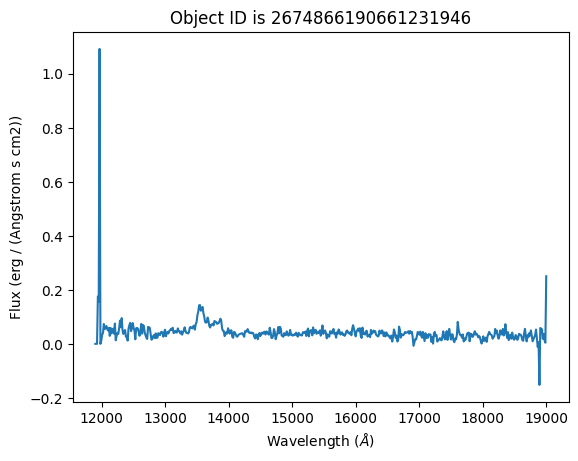

In [26]:
## Now the data are read in, show an image

plt.plot(df_obj_irsa['WAVELENGTH'], df_obj_irsa['SIGNAL'])

plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Flux (erg / (Angstrom s cm2))')
# plt.ylim(10,50)
plt.title('Object ID is '+str(obj_id))

Let's cut out a very small patch of the MER image to see what this galaxy looks like

In [27]:
## How large do you want the image cutout to be?
im_cutout= 2.0 * u.arcsec

## Use the ra and dec of the galaxy
ra = df_g_irsa[df_g_irsa['object_id']==obj_id]['ra'].iloc[0]
dec =  df_g_irsa[df_g_irsa['object_id']==obj_id]['dec'].iloc[0]

coords_cutout = SkyCoord(ra, dec, unit=(u.deg,u.deg), frame='icrs')

Use ``fsspec`` to obtain a cutout of the fits file

In [28]:
hdu = fits.open(filename, use_fsspec=True)

header = hdu[0].header

In [29]:
## Read in the cutout of the image that you want
cutout_data = Cutout2D(hdu[0].section, position=coords_cutout, size=im_cutout, wcs=WCS(hdu[0].header))

In [30]:
new_hdu = fits.PrimaryHDU(data=cutout_data.data, header=header)
new_hdu.header.update(cutout_data.wcs.to_header())

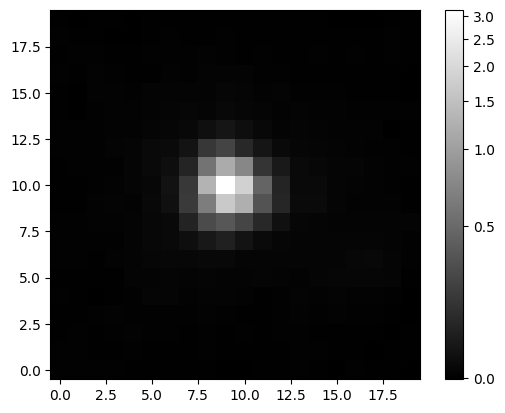

In [31]:
## Plot a quick simple plot to show the cutout on the galaxy

plt.imshow(new_hdu.data, cmap='gray', origin='lower',
           norm=ImageNormalize(new_hdu.data, interval=PercentileInterval(99.9), stretch=AsinhStretch()))
colorbar = plt.colorbar()

## 5. Load the image on Firefly to be able to interact with the data directly

Save the data locally if you have not already done so, in order to upload to IRSA viewer.

In [32]:
download_path = "data"
if os.path.exists(download_path):
    print("Output directory already created.")
else:
    print("Creating data directory.")
    os.mkdir(download_path)

Creating data directory.


### Vizualize the image with Firefly

First initialize the client, then set the path to the image, upload it to firefly, load it and align with WCS.

Note this can take a while to upload the full MER image.

In [33]:
fc = FireflyClient.make_client('https://irsa.ipac.caltech.edu/irsaviewer')

fc.show_fits(url=filename)

fc.align_images(lock_match=True)

{'success': True}

### Save the table as a CSV for Firefly upload

In [34]:
csv_path = os.path.join(download_path, "mer_df.csv")
df_g_irsa.to_csv(csv_path, index=False)

### Upload the CSV table to Firefly and display as an overlay on the FITS image

In [35]:
uploaded_table = fc.upload_file(csv_path)
print(f"Uploaded Table URL: {uploaded_table}")

fc.show_table(uploaded_table)

Uploaded Table URL: ${upload-dir}/upload_9887740898610742451_mer_df.csv


{'success': True}

## About this Notebook

**Author**: Tiffany Meshkat (IPAC Scientist)

**Updated**: 2025-03-19

**Contact:** [the IRSA Helpdesk](https://irsa.ipac.caltech.edu/docs/help_desk.html) with questions or reporting problems.